<a href="https://colab.research.google.com/github/ConceptaNjolima/RandomSamplingErrors/blob/main/ErrorsInEigenValueEstimatesViaRandomSampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import tarfile
import numpy as np 
import pandas
import csv
import io
import numpy as np
from numpy import matlib
from numpy import linalg as LA
import math
import random
from random import seed
import time
from numpy.core.getlimits import log10
import matplotlib.pyplot as plt
import networkx as nx
import scipy
from scipy.sparse import linalg
# from scipy.linalg import issymmetric
import scipy.sparse as sci
import itertools
import scipy.io as sio
from scipy.sparse.linalg import ArpackNoConvergence

In [5]:
# !pip install scipy==1.8
# ensure scipy version is 1.8
print(scipy.__version__)

1.8.0


In [ ]:
import gzip
# import shutil
with gzip.open('drive/MyDrive/Colab_Notebooks/email-Eu-core.txt.gz', 'rb') as f_in:
    line=f_in.read().decode("utf-8")
    nodes=line.split("\n")
    with open('drive/MyDrive/Colab_Notebooks/emailData.txt', 'w') as f_out:
      for node in nodes:
        nodeList=node.split(" ")
        if len(nodeList)<2:
          continue
        writeFormat=nodeList[0]+" "+nodeList[1]+"\n"
        f_out.write(writeFormat)

In [6]:
#Read edges from txt file
edgesList=open("drive/MyDrive/Colab_Notebooks/emailData.txt",'r')
edges=[]
for line in edgesList :
  nodeList=line.strip().split(" ")
  fromNode=int(nodeList[0])
  toNode=int(nodeList[1])
  edges.append((fromNode,toNode))
print(len(edges))

25571


In [7]:

G=nx.Graph()
G.add_edges_from(edges)
# nx.draw(G)
# print(type(G))

In [8]:
A=nx.adjacency_matrix(G)


<ipython-input-8-14b7cd0a7959>:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A=nx.adjacency_matrix(G)


In [ ]:
sio.savemat("drive/MyDrive/Colab_Notebooks/emailAdjacency.mat",{"emailAdjacency":A})

In [9]:
print(type(A))
A_large=(A+sci.csc_matrix.transpose(A))
print(np.shape(A_large))


<class 'scipy.sparse._csr.csr_matrix'>
(1005, 1005)


In [ ]:
def get_items(s):
    s_coo = s.tocoo()
    return set(zip(s_coo.row, s_coo.col))
# print((0,1) in get_items(A))

In [ ]:
# np.diagonal(A_large)

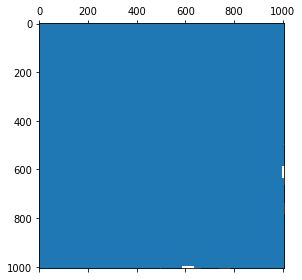

In [ ]:
plt.spy(A)

In [10]:
#Get n value
n=np.shape(A_large)[0]
print("size of A_large", np.shape(A_large))
print("n",n)
def getEigenEstimates(s):
  """
  A function that gets an sxs random submatrix 
  Params: s: the dimension of the sub matrix
  Return: np array of eigen estimates of the submatrix
  """
  A_s=[]
  subIndices=[]
  #set a seed that changes based on the clock to get more random choices
  seed(time.time())
  start_time=time.time()
  # Randomly select the indices to use in forming the principal sub matrix
  rng = np.random.default_rng()
  subIndices=rng.choice(n,s,replace=False)
  subIndices.sort()
  # subIndices=[0,1,2,3]
  subIndices=np.array(subIndices)

  # create the principal submatrix from the subIndices list
  A_s=A_large[subIndices[:,None],subIndices]

  # upcast the matrix to be with floats to prevent ValueError when calculating eigen values
  A_s=A_s.asfptype()
  
  # Compute the eigen Values and eigen vector of the principal submatrix
  largestEigenValues,largestEigenVector=linalg.eigs(A_s,k=10,which='LR')
  smallestEigenValues,smallestEigenVector=linalg.eigs(A_s,k=10,which='SR',maxiter=10000)
  eigenEstimates=np.hstack((np.real(largestEigenValues),np.real(smallestEigenValues)))*(n/s)

  return np.array(eigenEstimates)
# getEigenEstimates(5000)

size of A_large (1005, 1005)
n 1005


In [11]:
n=np.shape(A_large)[0]
def getSparseEigenEstimates(s):
  diagonalValues=[]
  # get probabilities 
  totalNnz=sci.csc_matrix.count_nonzero(A_large)
  nnzRow=(A_large!=0).sum(0)
  probList=list((nnzRow/totalNnz).flat)
  rng = np.random.default_rng()
  subIndices=rng.choice(n,s,replace=False,p=probList)
  subIndices.sort()
  A_s=A_large[subIndices[:,None],subIndices]
  subIndexNnz=list(np.take(nnzRow,subIndices).flat)
  diagonalValues=np.sqrt(totalNnz/(np.array(subIndexNnz)*s))
  diagonal=sci.diags(diagonalValues)
  A_sFinal=(diagonal.dot(A_s)).dot(diagonal)
  A_sFinal=A_sFinal.asfptype()
    # Compute the eigen Values and eigen vector of the principal submatrix
  largestEigenValues=linalg.eigs(A_sFinal,k=10,which='LR')[0]
  try:
    smallestEigenValues=linalg.eigs(A_sFinal,k=10,which='SR')[0]
  except ArpackNoConvergence:
    print("in except")
    getSparseEigenEstimates(s)
  eigenEstimates=np.hstack((np.real(largestEigenValues),np.real(smallestEigenValues)))
  # print("estimate", eigenEstimates)
  return np.array(eigenEstimates),np.array(probList)
  
getSparseEigenEstimates(100)


(array([149.68161874,  93.62857143,  91.31436022,  86.21214592,
         81.16124595,  77.96544826,  73.61569851,  69.37450269,
         70.2328872 ,  63.28233154, -51.42287751, -47.72858953,
        -45.39462118, -43.76543134, -41.35066428, -39.90630986,
        -37.64589731, -35.73017143, -33.76261491, -32.50210197]),
 array([1.31217577e-03, 1.55630150e-03, 2.86847727e-03, ...,
        3.05157156e-05, 3.05157156e-05, 3.05157156e-05]))

In [ ]:
# est1,prob1=getSparseEigenEstimates(50)
# fig1,ax1=plt.subplots()
# ax1.hist(np.matrix(prob1).getA1(),bins=30)

In [12]:
A_large=A_large.asfptype()
# True eigen values
largestTrueValues,largestTrueVector=linalg.eigs(A_large,k=10,which='LR')
smallestTrueValues,smallestTrueVector=linalg.eigs(A_large,k=10,which='SR')
trueEigenValues=np.hstack((np.real(largestTrueValues),np.real(smallestTrueValues)))
print(trueEigenValues)

[154.34352456  73.8754083   68.11601557  64.36903933  60.96012676
  52.68906261  46.55795866  45.04050467  44.21572406  39.74449087
 -48.64104521 -29.40676609 -25.11566457 -24.99826335 -24.27420439
 -23.608473   -23.59327379 -23.07225524 -22.85392152 -22.42610666]


In [13]:
def getLinfinityError(estimateValues):
  """
  A function that calculates the LInfinity error for the list of estimated eigenvalues
  Params: estimateValues: A list of estimated eigenvalues
  Return: maximum absolute value of all the errors calculated
  """
  # print(len(trueEigenValues),len(estimateValues))
  ErrorValues=np.subtract(trueEigenValues,estimateValues)
  return np.amax(np.absolute(ErrorValues))

[157.5065399050188, 45.28822805888959, 90.1558975335821, 72.42885171642595, 71.76903613969804, 60.755184714673334, 71.76903613969799, 99.2058092518578, 111.25175224219285, 64.46322168232443, 114.70354464472581, 68.5824155129678, 78.75696775606403, 106.50100231968622, 92.21219554593057, 63.43514462145528, 106.62207424906595, 64.12314210341975, 85.52559803385029, 101.2261859032522, 58.24834670657265, 113.38173455239621, 83.68658987712462, 108.09975585160205, 94.40036420166908, 501.0564754367533, 50.88156141640606, 67.92137767668291, 115.12667348714379, 69.1049396878866, 82.79324892264347, 94.87349360121266, 76.36149954121214, 66.13944614605475, 46.17564814973288, 60.637330873292925, 89.05951942339058, 73.7489711319646, 66.97070508098591, 97.46227238450419, 69.88816151246013, 146.72678311680508, 151.69917634688608, 51.047620789238366, 87.67928299096704, 69.07288143656169, 79.11820908111406, 89.9745916952532, 77.55721500699516, 120.25781190963576, 68.57808016470264, 83.83104914865038, 46.8

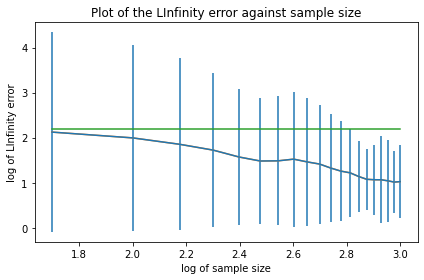

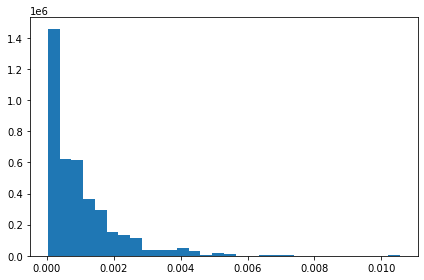

In [ ]:

def LInfinitySparseSampling():
  p=50
  xAxis=[]
  yAxisLInfinity=[]
  yAxisNoAlgorithm=[]
  standardErrors=[]
  probabilityList=[]
  while p<=n-2:
    LInfinityErrors=[]
    NoAlgorithmErrors=[]
    for i in range(200):
      eigenValueEstimates,probabilities=getSparseEigenEstimates(p)
      probabilityList.append(probabilities)
      # eigenValueEstimates=getSparseEigenEstimates(p)
      LInfinityError=getLinfinityError(eigenValueEstimates)
      LInfinityErrors.append(LInfinityError)
    # Considering the case when all eigen values are considered to be 0
    NoAlgorithmErrors.append(getLinfinityError([0]*(20)))
    print(LInfinityErrors)
    LInfinityAverageError=sum(LInfinityErrors)/len(LInfinityErrors)
    LInfinityStandardError=np.std(LInfinityErrors)
    logn=log10(p)
    xAxis.append(logn)
    yAxisLInfinity.append(LInfinityAverageError)
    standardErrors.append(LInfinityStandardError)
    yAxisNoAlgorithm.append(sum(NoAlgorithmErrors)/len(NoAlgorithmErrors))
    print(p)
    p+=50
  print(yAxisLInfinity)
  plt.errorbar(xAxis,log10(yAxisLInfinity),log10(standardErrors))
  plt.plot(xAxis, log10(yAxisLInfinity), xAxis,log10(yAxisNoAlgorithm))
  plt.title("Plot of the LInfinity error against sample size")
  plt.xlabel("log of sample size")
  plt.ylabel("log of LInfinity error")
  # plt.savefig("drive/MyDrive/Colab_Notebooks/LInfinityWithLargeMatrix.png")
  fig,ax=plt.subplots()
  ax.hist(np.matrix(probabilityList).getA1(),bins=30)
LInfinitySparseSampling()

60
110
160
210
260
310
360
410
460
510
560
610
660
710
760
810
860
910
960
[188.39153614839114, 120.38845181678973, 70.92796968830588, 48.86812215921817, 34.226875548447836, 21.42497556027486, 14.745858997880447, 12.263669773370665, 11.092224771894653, 10.659371657271953, 8.279104400917312, 5.754022864234254, 3.734833590892466, 2.353884764254531, 1.4198911036939057, 0.7633039000729923, 0.3536801343662109, 0.13469000690109692, 0.03838521250626306]


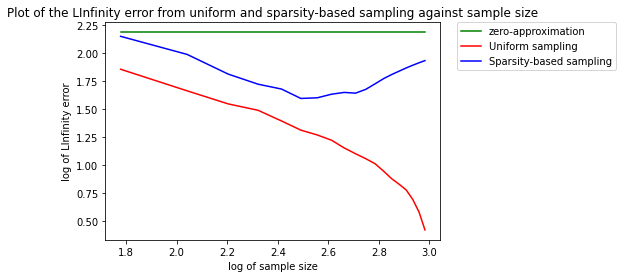

In [14]:

def LInfinityForVaryingSample():
  p=60
  xAxis=[]
  yAxisLInfinity=[]
  yAxisSparseLInfinity=[]
  yAxisNoAlgorithm=[]
  standardErrors=[]
  standardErrorsSparse=[]
  # probabilityList=[]
  while p<=n:
    LInfinityErrors=[]
    NoAlgorithmErrors=[]
    LInfinityErrorSparse=[]
    for i in range(200):
      # eigenValueEstimates,probabilities=getSparseEigenEstimates(p)
      # probabilityList.append(probabilities)
      eigenValueEstimates=getEigenEstimates(p)
      eigenSparseEstimates=getSparseEigenEstimates(p)[0]
      LInfinityError=getLinfinityError(eigenValueEstimates)
      LInfinitySparse=getLinfinityError(eigenSparseEstimates)
      LInfinityErrors.append(LInfinityError)
      LInfinityErrorSparse.append(LInfinitySparse)
    # Considering the case when all eigen values are considered to be 0
    NoAlgorithmErrors.append(getLinfinityError([0]*(20)))
    LInfinityAverageError=sum(LInfinityErrors)/len(LInfinityErrors)
    LInfinityAverageSparse=sum(LInfinityErrorSparse)/len(LInfinityErrorSparse)
    LInfinityStandardError=np.std(LInfinityErrors)
    LInfinitySparseStandard=np.std(LInfinityErrorSparse)
    logn=log10(p)
    xAxis.append(logn)
    yAxisLInfinity.append(LInfinityAverageError)
    yAxisSparseLInfinity.append(LInfinityAverageSparse)
    standardErrors.append(LInfinityStandardError)
    standardErrorsSparse.append(LInfinitySparseStandard)
    yAxisNoAlgorithm.append(sum(NoAlgorithmErrors)/len(NoAlgorithmErrors))
    print(p)
    p+=50
  print(standardErrorsSparse)
  labels=["zero-approximation","Uniform sampling","Sparsity-based sampling"]
  # plt.errorbar(xAxis,log10(yAxisLInfinity),log10(yAxisSparseLInfinity)log10(standardErrors),ecolor="red")
  plt.plot(xAxis,log10(yAxisNoAlgorithm),"green",label=labels[0])
  plt.plot(xAxis, log10(yAxisLInfinity),"red",label=labels[1])
  # plt.errorbar(xAxis,log10(yAxisSparseLInfinity),log10(standardErrorsSparse),ecolor="blue",label="zero-approximation")
  plt.plot(xAxis, log10(yAxisSparseLInfinity),"blue",label=labels[2])
  plt.title("Plot of the LInfinity error from uniform and sparsity-based sampling against sample size")
  plt.xlabel("log of sample size")
  plt.ylabel("log of LInfinity error")
  # plt.rcParams["figure.figsize"] = (8,8)
  plt.legend(labels,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

LInfinityForVaryingSample()

In [ ]:
sample_size=int(100)
LInfinityErrors=[]
for i in range(100):
  eigenEstimates=getSparseEigenEstimates(sample_size)[0]
  singleLInfinityError=getLinfinityError(eigenEstimates)
  LInfinityErrors.append(singleLInfinityError)

In [ ]:
largestEig,allVectors=linalg.eigs(A_large,k=1,which="LR")
lMax=float(np.real(largestEig))
print(lMax)

418.50293349272084


In [53]:
def machenkoPdf(n,sample_size,lMax):
  Q=n/sample_size
  inv_sqQ=1.0/np.sqrt(Q)
  sigma_2=lMax/np.square(1+inv_sqQ)
  sigma=np.sqrt(sigma_2)
  y=1/Q
  b=np.power(sigma*(1+np.sqrt(1/Q)),2)
  a=np.power(sigma*(1-np.sqrt(1/Q)),2)
  x=np.arange(a,b)
  mp=(1/(2*np.pi*sigma*sigma*x*y))*np.sqrt((b-x)*(x-a))

  #Scale the machenko-pastur pdfs by the number trials
  return (x, 1000*mp)

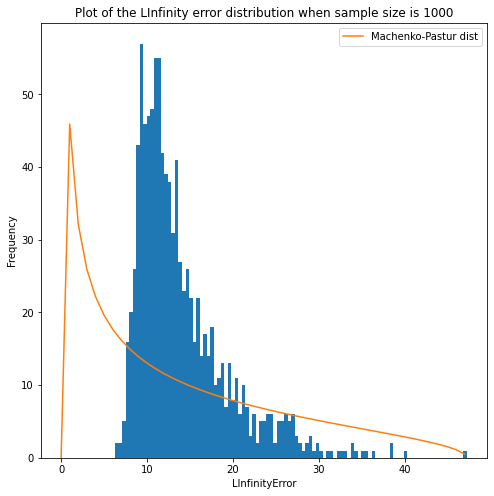

In [28]:
#Error distribution for LInfinity error
def plotLInfinityErrorDistribution(sample_size):
  LInfinityErrors=[]
  for i in range(1000):
    eigenEstimates=getEigenEstimates(sample_size)
    singleLInfinityError=getLinfinityError(eigenEstimates)
    LInfinityErrors.append(singleLInfinityError)
  x,pdf=machenkoPdf(n,sample_size,max(LInfinityErrors))
  #Plot histogram of the error distribiution
  label=["Machenko-Pastur dist"]
  fig,ax=plt.subplots()
  ax.hist(LInfinityErrors,bins=int(sample_size/10))
  plt.plot(x,pdf,label=label[0])
  plt.title("Plot of the LInfinity error distribution when sample size is "+ str(sample_size))
  plt.ylabel("Frequency")
  plt.xlabel("LInfinityError")
  plt.legend(label,loc='best')
  # fig.savefig("drive/MyDrive/Colab_Notebooks/LinifinityErrorDist.png")

sample_size=int(1000)
plotLInfinityErrorDistribution(sample_size)
# while sample_size<=n:
#   plotLInfinityErrorDistribution(sample_size)
#   sample_size+=100

In [13]:

def calculatePerEntryError(estimateValues):
  """
  A function to calculate the error for each eigenvalue estimate
  Params: estimateValues: A list of eigenValue estimates from the uniform random sampling algorithm
  Return: PErrorList: A list of the errors for each eigenvalue estimate
  """
  pErrorList=[]
  topTrueEigenValues=trueEigenValues[:5]
  lastTrueEigenValues=trueEigenValues[-5:]
  trueEigenNeeded=np.hstack([topTrueEigenValues,lastTrueEigenValues])
  pErrorList=np.abs(np.subtract(trueEigenNeeded,estimateValues))
  return pErrorList

In [ ]:
def getPerEntryError():
  """
  A function that calculates and plots the per-entry error 
  for the top five positive and top five negative eigen estimates
  Return: perEigenDict: key-value pairs of the per-entry errors
          LInfinityErrors: The L-Infinity errors from the estimates

  """
  p=100
  PerEntryErrors={}
  LInfinityErrors={}
  # i=0
  while p<=n:
    eigenValueEstimates=getEigenEstimates(p)
    # Get top five positive and top five negative
    topFive=eigenValueEstimates[:5]
    lastFive=eigenValueEstimates[-5:]
    estimatesNeeded=np.hstack([topFive,lastFive])
    PerEntryErrors[p]=calculatePerEntryError(estimatesNeeded)
    LInfinityErrors[p]=getLinfinityError(eigenValueEstimates)
    p+=100
  
  # Get the per-entry errors for each estimate
  perEigenErrorDict={}
  for i in range(10):
    perEigenError=[]
    for p in PerEntryErrors.keys():
      perEigenError.append((PerEntryErrors[p][i]))
    perEigenErrorDict[i]=perEigenError
  return (perEigenErrorDict,LInfinityErrors)

perEigenAverageErrors={}
LInfinityAverageErrors={}
#store all the repeats in a separate dictionary
(perEigenAverageErrors,LInfinityAverageErrors)=getPerEntryError()

#repeat per entry error for 1000 trials
for i in range(500):
  perEntryErrorReturned,LInfinityError=getPerEntryError()
  newPerEntryErrors=perEntryErrorReturned
  newLInfinityErrors=LInfinityError
  for j in perEigenAverageErrors.keys():
    perEigenAverageErrors[j]=np.mean(np.array([perEigenAverageErrors[j],newPerEntryErrors[j]]),axis=0)
  for k in LInfinityAverageErrors.keys():
    LInfinityAverageErrors[k]=np.mean(np.array([LInfinityAverageErrors[k],newLInfinityErrors[k]]),axis=0)

positiveLabels=["for positive estimate "+str(i) for i in range(5)]
negativeLabels=["for negative estimate "+str(i) for i in range(5)]
labels=positiveLabels+negativeLabels
xValues=np.log10(np.arange(int((n)/100)))
LInfinityErrors=log10(list(LInfinityAverageErrors.values()))
yValues=list(perEigenAverageErrors.values())

#Plot each per-entry error
for i in range(len(yValues)):
  plt.plot(xValues,log10(yValues[i]), label=labels[i])
labels.append("LInfinity error")
plt.plot(xValues,LInfinityErrors,label="LInfinity error", linestyle='dashed', marker='o')
plt.rcParams["figure.figsize"] = (8,8)
plt.legend(labels,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.title("Plot of Per-entry error approximation against sample size")
plt.xlabel("Log of sample size")
plt.ylabel("Log of per-entry error approximation")

In [2]:
#Get n value
n=np.shape(A_large)[0]
print("size of A_large", np.shape(A_large))
print("n",n)
def getKEigenEstimates(s,k):
  """
  A function that gets an sxs random submatrix 
  Params: s: the dimension of the sub matrix
  Return: np array of eigen estimates of the submatrix
  """
  A_s=[]
  subIndices=[]
  #set a seed that changes based on the clock to get more random choices
  seed(time.time())
  start_time=time.time()
  # Randomly select the indices to use in forming the principal sub matrix
  rng = np.random.default_rng()
  subIndices=rng.choice(n,s,replace=False)
  subIndices.sort()
  # subIndices=[0,1,2,3]
  subIndices=np.array(subIndices)

  # create the principal submatrix from the subIndices list
  A_s=A_large[subIndices[:,None],subIndices]

  # upcast the matrix to be with floats to prevent ValueError when calculating eigen values
  A_s=A_s.asfptype()
  
  # Compute the eigen Values and eigen vector of the principal submatrix
  largestEigenValues,largestEigenVector=linalg.eigs(A_s,k=k,which='LR')
  
  eigenEstimates=np.real(largestEigenValues)*(n/s)

  return eigenEstimates
# getKEigenEstimates(100,3)

NameError: ignored

In [1]:
from scipy.stats import norm
#Error distribution for LInfinity error
def plotTopTwoEigen(sample_size):
  firstEstimateErrors=[]
  secondEstimateErrors=[]
  for i in range(10000):
    firstEigenEstimate=getKEigenEstimates(sample_size,11)[6]
    secondEigenEstimate=getKEigenEstimates(sample_size,11)[7]
    firstError=firstEigenEstimate-trueEigenValues[6]
    secondError=secondEigenEstimate-trueEigenValues[7]
    firstEstimateErrors.append(firstError)
    secondEstimateErrors.append(secondError)
  #Plot histogram of the error distribiution
  mean1=np.mean(firstEigenEstimate)
  print(firstEstimateErrors)
  print(secondEstimateErrors)
  # sd1=np.std(firstEigenEstimate)
  # mu1, std1 = norm.fit(firstEigenEstimate)
  # x=np.arange(int(np.min(firstEigenEstimate)),int(np.max(firstEigenEstimate)),50)
  label=["Machenko-Pastur dist"]
  x1,pdf1=machenkoPdf(n,sample_size,max(abs(np.array(firstEstimateErrors))))
  x2,pdf2=machenkoPdf(n,sample_size,max(abs(np.array(secondEstimateErrors))))
  plt.rcParams["figure.figsize"] = (5,5)
  fig1,ax1=plt.subplots()
  fig2,ax2=plt.subplots()
  # p1 = norm.pdf(x, mu1, std1)
  # ax1.plot(x1,pdf1,label=label[0])
  # print(p1)
  # ax1.plot (x1,p1)
  ax1.hist(firstEstimateErrors,bins=int(sample_size/10))
  ax1.set_title("Plot of the error distribution of the top eigen value with s="+ str(sample_size))
  ax1.set(xlabel="Error",ylabel="Frequency")
  ax2.hist(secondEstimateErrors,bins=int(sample_size/10))
  # ax2.plot(x2,pdf2,label=label[0])
  ax2.set_title("Plot of the error distribution of the second eigen value with s="+ str(sample_size))
  ax2.set(xlabel="Error",ylabel="Frequency")
  plt.legend(label,loc='best')
  # fig.savefig("drive/MyDrive/Colab_Notebooks/LinifinityErrorDist.png")

sample_size=int(300)
plotTopTwoEigen(sample_size)
# while sample_size<=n:
#   plotLInfinityErrorDistribution(sample_size)
#   sample_size+=100

NameError: ignored